<a href="https://colab.research.google.com/github/emylincon/GridProject/blob/master/InceptionResNetV2_WithSkinDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip3 install keras==2.3.1

     |████████████████████████████████| 378kB 5.3MB/s 
     |████████████████████████████████| 51kB 5.2MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


In [3]:
import numpy as np
import pandas as pd
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

HEIGHT = 300
WIDTH = 300

base_model = InceptionResNetV2(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3))

219062272/219055592 [==============================] - 1s 0us/step


In [4]:
import os
os.chdir('drive/MyDrive/skin_detect/')
print(os.getcwd())

/content/drive/MyDrive/skin_detect


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TRAIN_DIR = "train/"
BATCH_SIZE = 8

train_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      # rescale=1./255,
      rotation_range=90,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True
    )

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, 
                                                    target_size=(HEIGHT, WIDTH), 
                                                    batch_size=BATCH_SIZE)


test_datagen =  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      # rescale=1./255,
      rotation_range=90,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      vertical_flip=True
    )
validation_generator = test_datagen.flow_from_directory(
        'test/',
        target_size=(HEIGHT, WIDTH),
        batch_size=BATCH_SIZE)

Found 374 images belonging to 2 classes.
Found 90 images belonging to 2 classes.


In [14]:
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.models import Sequential, Model

def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    for layer in base_model.layers:
        layer.trainable = False
    # for layer in base_model.layers[-2:]:
    #     layer.trainable = True

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        # New FC layer, random init
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(dropout)(x)

    # New softmax layer
    predictions = Dense(num_classes, activation='softmax')(x) 
    
    finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

class_list = os.listdir("train/")
FC_LAYERS = [1024, 1024]
dropout = 0.5

finetune_model = build_finetune_model(base_model, 
                                      dropout=dropout, 
                                      fc_layers=FC_LAYERS, 
                                      num_classes=len(class_list))

In [15]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

NUM_EPOCHS = 20
BATCH_SIZE = 16
num_train_images = 370

adam = Adam(lr=0.00001)
finetune_model.compile(adam, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

filepath="eff_checkpoint_" + "RES" + "_inception_weights.h5"
checkpoint = ModelCheckpoint(filepath, monitor=["acc"], verbose=1, mode='max')
callbacks_list = [checkpoint]

history = finetune_model.fit(train_generator, epochs=NUM_EPOCHS, workers=16, 
                                       steps_per_epoch=num_train_images // BATCH_SIZE, 
                                       shuffle=True, callbacks=callbacks_list, validation_data=validation_generator)

Epoch 1/20
23/23 [==============================] - 153s 6s/step - loss: 0.9647 - categorical_accuracy: 0.5247 - val_loss: 0.4838 - val_categorical_accuracy: 0.7667

Epoch 00001: saving model to eff_checkpoint_RES_inception_weights.h5
Epoch 2/20
23/23 [==============================] - 142s 6s/step - loss: 0.7749 - categorical_accuracy: 0.6773 - val_loss: 0.3494 - val_categorical_accuracy: 0.8667

Epoch 00002: saving model to eff_checkpoint_RES_inception_weights.h5
Epoch 3/20
23/23 [==============================] - 142s 6s/step - loss: 0.5783 - categorical_accuracy: 0.7794 - val_loss: 0.3808 - val_categorical_accuracy: 0.8333

Epoch 00003: saving model to eff_checkpoint_RES_inception_weights.h5
Epoch 4/20
23/23 [==============================] - 143s 6s/step - loss: 0.4802 - categorical_accuracy: 0.8429 - val_loss: 0.3693 - val_categorical_accuracy: 0.8556

Epoch 00004: saving model to eff_checkpoint_RES_inception_weights.h5
Epoch 5/20
23/23 [==============================] - 142s 6s/

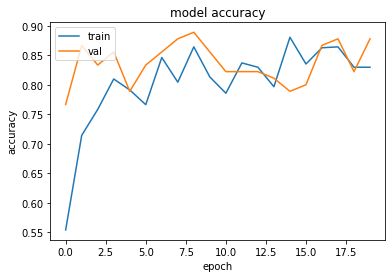

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [17]:
finetune_model.evaluate(validation_generator)

12/12 [==============================] - 41s 3s/step - loss: 0.3981 - categorical_accuracy: 0.8667


[0.39810439944267273, 0.8666666746139526]

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [18]:
predictions1 = finetune_model.predict(x=validation_generator, verbose=0)
cm = confusion_matrix(y_true=validation_generator.classes, y_pred=np.argmax(predictions1, axis=-1))

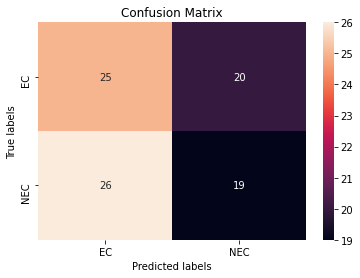

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt     

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['EC', 'NEC']); ax.yaxis.set_ticklabels(['EC', 'NEC']);